In [1]:
import numpy as np
np.random.seed(10)
import torch
import torch.nn as nn
torch.manual_seed(10)
import matplotlib.pyplot as plt
from torch.autograd import grad

In [2]:
# Hyper-parameters
input_size = 2
output_size = 1
num_epochs = 10000
learning_rate = 0.001

# Reynolds number
Rnum = 500.0

# Uniform samples in x, t
x_phys = np.linspace(0.0,1.0,num=128)
t_phys = np.linspace(0.0,1.0,num=100)

xx, tt = np.meshgrid(x_phys,t_phys) # https://www.geeksforgeeks.org/numpy-meshgrid-function/
input_points = np.concatenate((xx.reshape(-1,1),tt.reshape(-1,1)),axis=-1)

# Subsample for random probing of solution
idx = np.arange(input_points.shape[0])
np.random.shuffle(idx)
solution_points = input_points[idx[:100]]

# Data collection
def exact_solution(Rnum,data_points):
    x = data_points[:,0]
    t = data_points[:,1]
    t0 = np.exp(Rnum/8.0)
    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

# Sample for solution
solution_data = exact_solution(Rnum,solution_points).reshape(-1,1)
true_solution = exact_solution(Rnum,input_points).reshape(100,128)

# Sample for PDE residual
residual_points = input_points[100:2100]
num_residual_points = np.shape(input_points)[0]

# Sample for initial condition points
num_initial_points = 2000
x_ic = np.linspace(0.0,1.0,num=num_initial_points)
t_ic = 0.0*x_ic

initial_points = np.concatenate((x_ic.reshape(-1,1),t_ic.reshape(-1,1)),axis=-1)
initial_data = exact_solution(Rnum,initial_points).reshape(-1,1)

# Sample for boundary condition points
num_bc_points = 1000 # For each side
t_bc = np.linspace(0.0,2.0,num=num_bc_points)
x_bc_1 = 0.0*t_bc
x_bc_2 = 1.0+np.zeros_like(t_bc)

boundary_points_0 = np.concatenate((x_bc_1.reshape(-1,1),t_bc.reshape(-1,1)),axis=-1)
boundary_points_1 = np.concatenate((x_bc_2.reshape(-1,1),t_bc.reshape(-1,1)),axis=-1)
boundary_points = np.concatenate((boundary_points_0,boundary_points_1),axis=0)
boundary_data = exact_solution(Rnum,boundary_points).reshape(-1,1)

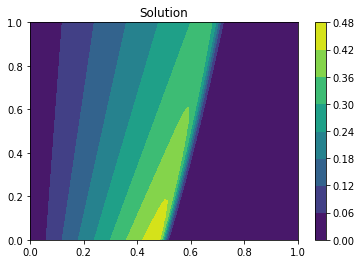

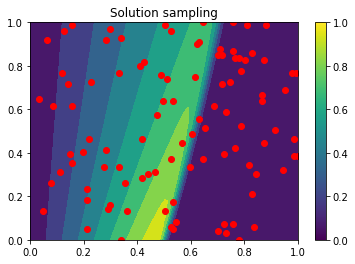

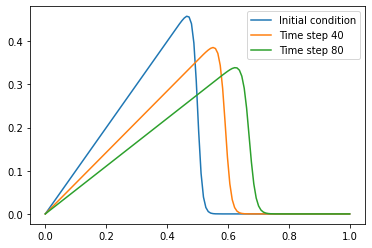

In [3]:
plt.figure()
plt.title('Solution')
plt.contourf(xx,tt,true_solution)
plt.colorbar()
plt.show()

plt.figure()
plt.title('Solution sampling')
plt.contourf(xx,tt,true_solution)
plt.scatter(solution_points[:,0],solution_points[:,1],color='red')
plt.colorbar()
plt.show()

plt.figure()
plt.plot(xx[0,:],true_solution[0,:],label='Initial condition')
plt.plot(xx[0,:],true_solution[40,:],label='Time step 40')
plt.plot(xx[0,:],true_solution[80,:],label='Time step 80')
plt.legend()
plt.show()

In [4]:
# Define the neural network
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.act = nn.Tanh()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, hidden_size)  
        self.fc4 = nn.Linear(hidden_size, hidden_size)  
        self.fc5 = nn.Linear(hidden_size, output_size)  
    
    def forward(self, x):
        hh = self.fc1(x)
        hh = self.act(hh)
        
        hh = self.fc2(hh)
        hh = self.act(hh)
        
        hh = self.fc3(hh)
        hh = self.act(hh)
        
        hh = self.fc4(hh)
        hh = self.act(hh)
        
        out = self.fc5(hh)
        
        return out
    
    def pde_residual(self,x):
        
        x.requires_grad_(True)
        u = self.forward(x)
        
        uxt = grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), allow_unused=True, create_graph=True, retain_graph=True)[0]
        ux = uxt[:,0:1]
        ut = uxt[:,1:]
               
        uxx = grad(outputs=ux, inputs=x, grad_outputs=torch.ones_like(ux), allow_unused=True, create_graph=True, retain_graph=True)[0]
        
        x.requires_grad_(False)
        
        pde_res = ((ut + u*ux -1.0/Rnum*uxx)**2)

        return torch.sum(pde_res)/num_residual_points        

In [5]:
# Fully connected neural network
model = NeuralNet(input_size, 40, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Early stopping
best_loss = 100.0
max_stop_iter = 100
stop_iter = 0

# Train the model
for epoch in range(num_epochs):
    
    epoch_total_loss=0.0
    epoch_l2_loss=0.0
    epoch_pde_res=0.0
    epoch_init_res_loss=0.0
    epoch_bc_res_loss=0.0
    
    for i in range(10):
        x_train = solution_points[i*10:(i+1)*10]
        y_train = solution_data[i*10:(i+1)*10]
    
        # Convert numpy arrays to torch tensors
        inputs = torch.from_numpy(x_train).float()
        targets = torch.from_numpy(y_train).float()

        # Forward pass - L2
        outputs = model(inputs)
        l2_loss = criterion(outputs, targets)
        
        # Forward pass - PDE residual
        pde_res = model.pde_residual(torch.from_numpy(input_points[i*10:(i+1)*10]).float())
        
        # Forward pass - Initial residual
        inputs = torch.from_numpy(initial_points[i*10:(i+1)*10]).float()
        targets = torch.from_numpy(initial_data[i*10:(i+1)*10]).float()
        outputs = model(inputs)
        init_res_loss = criterion(outputs, targets)
        
        # Forward pass - Boundary residual
        inputs = torch.from_numpy(boundary_points[i*10:(i+1)*10]).float()
        targets = torch.from_numpy(boundary_data[i*10:(i+1)*10]).float()
        outputs = model(inputs)
        bc_res_loss = criterion(outputs, targets)
                
        # Backward and optimize
        optimizer.zero_grad()
        
        # Total loss
        total_loss = l2_loss + pde_res + init_res_loss + bc_res_loss
        
        total_loss.backward()
        optimizer.step()
        
        # Sum
        epoch_total_loss+=total_loss
        epoch_l2_loss+=l2_loss
        epoch_pde_res+=pde_res
        epoch_init_res_loss+=init_res_loss
        epoch_bc_res_loss+=bc_res_loss
        
    if epoch_total_loss<best_loss:
        best_loss = epoch_total_loss
        stop_iter = 0
    else:
        stop_iter+=1
        
    if stop_iter > max_stop_iter:
        break
        
    
    if (epoch+1) % 5 == 0:
        print ('Losses for Epoch [{}/{}], L2: {:.4f}, PDE: {:.4f}, IC: {:.4f}, BC: {:.4f}'.format(epoch+1, 
                                                                                      num_epochs, 
                                                                                      epoch_l2_loss.item(), 
                                                                                      epoch_pde_res.item(),  
                                                                                      epoch_init_res_loss.item(), 
                                                                                      epoch_bc_res_loss.item()))

Losses for Epoch [5/10000], L2: 0.1991, PDE: 0.0002, IC: 0.0015, BC: 0.0121
Losses for Epoch [10/10000], L2: 0.1950, PDE: 0.0003, IC: 0.0017, BC: 0.0116
Losses for Epoch [15/10000], L2: 0.1876, PDE: 0.0003, IC: 0.0016, BC: 0.0120
Losses for Epoch [20/10000], L2: 0.1697, PDE: 0.0003, IC: 0.0013, BC: 0.0130
Losses for Epoch [25/10000], L2: 0.1383, PDE: 0.0003, IC: 0.0029, BC: 0.0135
Losses for Epoch [30/10000], L2: 0.1136, PDE: 0.0002, IC: 0.0032, BC: 0.0093
Losses for Epoch [35/10000], L2: 0.0911, PDE: 0.0002, IC: 0.0014, BC: 0.0031
Losses for Epoch [40/10000], L2: 0.0773, PDE: 0.0001, IC: 0.0011, BC: 0.0016
Losses for Epoch [45/10000], L2: 0.0705, PDE: 0.0001, IC: 0.0008, BC: 0.0007
Losses for Epoch [50/10000], L2: 0.0657, PDE: 0.0001, IC: 0.0005, BC: 0.0003
Losses for Epoch [55/10000], L2: 0.0619, PDE: 0.0001, IC: 0.0003, BC: 0.0002
Losses for Epoch [60/10000], L2: 0.0588, PDE: 0.0001, IC: 0.0002, BC: 0.0003
Losses for Epoch [65/10000], L2: 0.0557, PDE: 0.0001, IC: 0.0002, BC: 0.0003


Losses for Epoch [535/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [540/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [545/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [550/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [555/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [560/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [565/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [570/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [575/10000], L2: 0.0004, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [580/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0002
Losses for Epoch [585/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0002, BC: 0.0001
Losses for Epoch [590/10000], L2: 0.0003, PDE: 0.0006, IC: 0.0001, BC: 0.0001
Losses for Epoch [595/10000], L2: 0.0002, PDE: 0.0006, IC: 0.000

In [6]:
# Plot the field
input_points = np.concatenate((xx.reshape(-1,1),tt.reshape(-1,1)),axis=-1)
predicted = model(torch.from_numpy(input_points).float()).detach().numpy()
predicted = predicted.reshape(100,128)

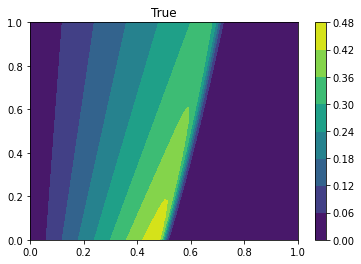

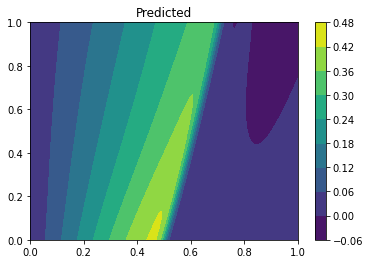

In [7]:
plt.figure()
plt.title('True')
plt.contourf(xx,tt,true_solution)
plt.colorbar()
plt.show()

plt.figure()
plt.title('Predicted')
plt.contourf(xx,tt,predicted)
plt.colorbar()
plt.show()

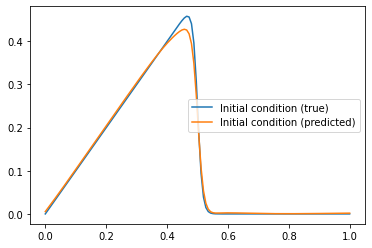

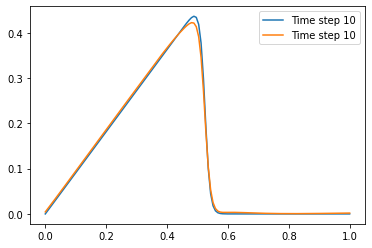

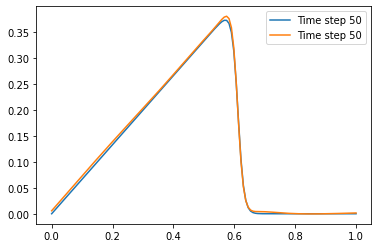

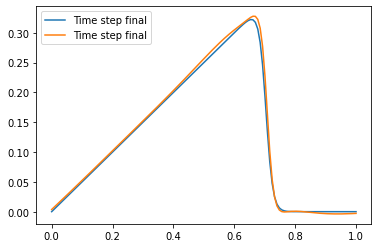

In [8]:
plt.figure()
plt.plot(xx[0,:],true_solution[0,:],label='Initial condition (true)')
plt.plot(xx[0,:],predicted[0,:],label='Initial condition (predicted)')
plt.legend()
plt.show()

plt.figure()
plt.plot(xx[0,:],true_solution[10,:],label='Time step 10')
plt.plot(xx[0,:],predicted[10,:],label='Time step 10')
plt.legend()
plt.show()

plt.figure()
plt.plot(xx[0,:],true_solution[50,:],label='Time step 50')
plt.plot(xx[0,:],predicted[50,:],label='Time step 50')
plt.legend()
plt.show()

plt.figure()
plt.plot(xx[0,:],true_solution[-1,:],label='Time step final')
plt.plot(xx[0,:],predicted[-1,:],label='Time step final')
plt.legend()
plt.show()

In [9]:
# Find errors
mse = np.mean((predicted-true_solution)**2)
print('Mean squared error:',mse)

Mean squared error: 2.475253388069085e-05


In [10]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')